In [14]:
# general imports
import pandas as pd
import numpy as np
import os
from IPython.display import display
pd.options.display.max_columns = None

from util.cloud_connection import bucket_connection
from src.recommender import recommender


recommender = recommender.Recommender()

Blob meal.csv downloaded to /home/oli/Repos/tuk.mensa-kl-conv-ai/meal_tmp.csv.


# Enrich sparse matrix through SVD

Motivated through [this blog post](http://nicolas-hug.com/blog/matrix_facto_4), the `surprise` framework will however (due to lacking docs) not utilized...

From the `sklearn.cecomposition.TruncatedSVD` [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html):

```
"Dimensionality reduction using truncated SVD (aka LSA).

This transformer performs linear dimensionality reduction by means of truncated singular value decomposition (SVD). Contrary to PCA, this estimator does not center the data before computing the singular value decomposition. This means it can work with scipy.sparse matrices efficiently.

In particular, truncated SVD works on term count/tf-idf matrices as returned by the vectorizers in sklearn.feature_extraction.text. In that context, it is known as latent semantic analysis (LSA).

This estimator supports two algorithms: a fast randomized SVD solver, and a “naive” algorithm that uses ARPACK as an eigensolver on (X * X.T) or (X.T * X), whichever is more efficient."
```

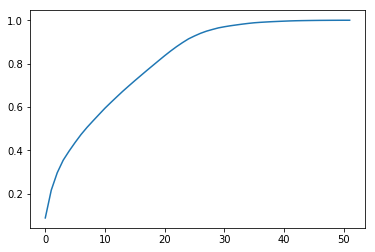

In [64]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

SVD_K = 52    # only consider 10 most dominant 

df = recommender.user_similarity

svd = TruncatedSVD(SVD_K)
df = pd.DataFrame(svd.fit_transform(df))

vars_accum_sums = [svd.explained_variance_ratio_[:(i+1)].sum() for i in range(52)]
plt.plot(vars_accum_sums)
plt.show()

In [149]:
n_factors = 30  # number of factors
alpha = .01  # learning rate
n_epochs = 200  # number of iteration of the SGD procedure

class sparseSVD:
    
    def __init__(self, data):
        self.p = np.random.normal(0, .1, (data['n_users'], n_factors))
        self.q = np.random.normal(0, .1, (data['n_items'], n_factors))

    def SGD(self, data):
        '''Learn the vectors p_u and q_i with SGD.
           data is a dataset containing all ratings + some useful info (e.g. number
           of items/users).
        '''


        # Randomly initialize the user and item factors.
        p = np.random.normal(0, .1, (data['n_users'], n_factors))
        q = np.random.normal(0, .1, (data['n_items'], n_factors))

        # Optimization procedure
        for _ in range(n_epochs):
            for u, i, r_ui in data['all_ratings']:
                err = r_ui - np.dot(p[u], q[i])
                # Update vectors p_u and q_i
                p[u] += alpha * err * q[i]
                q[i] += alpha * err * p[u]
        
        self.p = p
        self.q = q
            
    def estimate(self, u, i):
        '''Estimate rating of user u for item i.'''
        return np.dot(self.p[u], self.q[i])


df = recommender.df_user_item
data = {
    'n_users': df.shape[0],
    'n_items': df.shape[1],
    'all_ratings': [(u,i, df.iloc[u,i]) for u in range(df.shape[0]) for i in range(df.shape[1]) if df.iloc[u,i] > 0]
}

svd = sparseSVD(data)
svd.SGD(data)

# svd.estimate(51,76)
# data['all_ratings']

# for idx, row in df.iterrows():
#     for i in row.size:


new_pred = np.zeros(df.shape)
for u in range(df.shape[0]):
    for i in range(df.shape[1]):
        new_pred[u,i] = svd.estimate(u,i)
#         if df.iloc[u,i] > 0:
#             print("{},{}:\t actual={} \t predicted={}".format(u,i,df.iloc[u,i],svd.estimate(u,i)))
df_new_pred = pd.DataFrame(new_pred, index=recommender.df_user_item.index, columns=recommender.df_user_item.columns)

df_new_pred.head()


m_id,57,115,135,160,166,167,174,192,204,210,212,219,224,236,241,242,249,263,289,302,303,315,316,323,342,344,352,353,358,359,360,364,370,372,375,376,379,380,390,395,401,403,404,410,417,420,423,431,432,444,447,449,450,453,456,457,458,459,462,464,466,469,471,474,475,476,483,485,489,492,493,494,495,498,499,504,507,510,515,520,521,523,524,527,530,532,533,534,535,536,538,539,543,545,546,548,549,550,551,554,555,556,558,563,566,567,568,570,571,573,579,580,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601
user,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.920834,0.296607,0.474178,0.430263,0.348000,0.420072,0.340808,0.057838,0.641551,0.409369,0.183497,0.722634,0.539130,0.669552,0.809983,0.740151,0.527993,-0.470252,0.787269,0.227194,0.321319,0.615379,0.729166,0.874262,0.599710,-0.182827,0.459946,0.516934,0.402711,0.844102,0.741950,0.294109,0.100798,0.232646,1.008514,0.283544,0.131321,0.663416,0.606846,0.059841,0.082430,0.527085,0.258500,0.686368,0.412709,0.573743,0.279100,0.147740,-0.128854,0.875403,0.734024,0.920600,0.628845,0.659997,0.338076,0.478308,0.716789,0.714381,0.475199,0.485036,0.510199,1.134318,0.116487,0.774668,0.185743,0.054887,0.826882,0.665279,-0.019253,0.977225,0.542363,0.092172,1.198020,-0.236455,0.435089,0.868944,0.172494,0.292640,0.435323,0.328703,0.105067,0.684953,0.693968,0.008724,0.982579,0.454673,0.464155,-0.015796,0.350513,0.612265,0.711709,0.200556,0.807992,0.118179,0.798703,1.218848,0.862816,0.608444,0.236748,0.010019,0.471206,0.612448,0.328915,0.545515,0.669812,0.684270,0.340947,0.968083,0.411452,0.702060,0.802290,0.297802,0.384870,0.101059,0.438371,0.272918,-0.168079,0.422558,0.190852,0.034756,0.417598,0.310100,0.700455,0.469226,0.680378,0.501674,0.728629,0.726870,0.849695,0.065143,0.501608,0.012337
2,0.039476,0.533365,0.088608,0.383073,0.304378,0.073661,0.541802,0.082033,0.643150,0.350970,-0.089572,0.420542,0.709599,0.036872,0.435192,0.443018,0.579697,0.707294,0.541525,-0.095426,0.192187,0.371634,0.099146,0.110018,0.479296,0.171342,0.732278,0.493340,0.000533,0.045520,-0.133068,0.259494,0.013722,0.354796,0.210135,0.286433,0.014194,0.283984,0.358961,0.170089,0.142751,0.448935,0.027344,0.045262,0.126178,0.563740,-0.127721,0.126368,0.322078,0.262062,-0.006972,0.521660,-0.242428,0.155853,0.600256,0.284228,0.063186,-0.005010,0.611694,0.244087,0.243123,0.466870,0.152742,0.610585,-0.105396,-0.013343,0.319529,0.585410,0.735418,0.151483,0.061240,-0.007059,0.103900,0.014126,1.140571,0.428715,-0.069778,0.573478,0.458194,0.242532,0.328366,0.474679,-0.033577,0.723280,0.230958,0.859255,0.794009,0.025545,0.549950,0.526213,0.436110,0.067388,0.425192,0.095953,0.492239,0.332985,0.459658,-0.123697,0.364868,0.403034,0.220348,0.898715,0.861245,1.062140,0.999025,0.120341,0.189359,0.750467,0.418952,0.406463,-0.274401,0.534707,0.683326,1.099127,0.575689,0.137645,0.594459,0.417713,0.570952,0.159624,0.089050,0.791710,0.580084,0.489501,0.286189,0.555639,0.076258,-0.015318,0.799579,0.208072,0.613728,0.305233
3,0.417380,1.211004,2.076052,1.240991,0.974679,1.085376,0.387430,0.484644,1.009399,0.500416,1.146545,1.976089,1.251005,1.984332,1.446256,0.868056,0.737065,2.014746,1.460984,-0.062770,0.633905,1.175783,1.241258,1.325031,1.446553,0.804212,1.821265,1.264126,0.996870,1.748065,1.106583,0.439038,0.215903,0.546834,1.662746,0.775410,0.205727,1.524537,2.094945,0.468922,0.509819,0.828954,0.272136,1.012062,1.133982,1.892019,0.165188,0.248062,1.249456,1.122818,1.110409,1.430649,1.123908,1.249069,0.528778,1.513930,1.139754,1.308075,1.268697,1.483686,1.135737,1.599105,0.589962,1.622752,-0.127857,0.165215,1.259450,1.641761,1.458840,0.559376,0.810692,0.343609,1.281300,0.818206,2.053691,2.442214,0.996470,1.801291,1.381483,0.476441,0.323036,0.890386,1.154814,1.525428,1.936960,0.978457,1.613221,0.049601,0.717792,1.189924,1.417674,0.376136,1.008696,0.564603,1.946605,1.888479,0.739217,1.069353,0.164737,1.123274,1.697042,1.306977,0.71428

In [143]:
recommender.df_user_item.head()

m_id,57,115,135,160,166,167,174,192,204,210,212,219,224,236,241,242,249,263,289,302,303,315,316,323,342,344,352,353,358,359,360,364,370,372,375,376,379,380,390,395,401,403,404,410,417,420,423,431,432,444,447,449,450,453,456,457,458,459,462,464,466,469,471,474,475,476,483,485,489,492,493,494,495,498,499,504,507,510,515,520,521,523,524,527,530,532,533,534,535,536,538,539,543,545,546,548,549,550,551,554,555,556,558,563,566,567,568,570,571,573,579,580,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601
user,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
